In [1]:
# load the required modules
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import cv2
import os
import csv
import argparse
import scipy.misc

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization,Input
from keras.layers import Conv2D, MaxPooling2D,MaxPooling3D, GlobalAveragePooling2D
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.
C:\Users\Namita\Anaconda2\envs\dog-project\lib\site-packages\pydot.py:17: UserWarning: Couldn't import dot_parser, loading of dot files will not be possible.
  "Couldn't import dot_parser, "


In [2]:
# coding: utf-8

'''
This script creates 3-channel gray images from FER 2013 dataset.
It has been done so that the CNNs designed for RGB images can 
be used without modifying the input shape. 
It generates the images and saves them in three directories inside 
the output directory - Training, PublicTest, and PrivateTest. 
These are the three original splits in the dataset. 

File and output folder are the below variables.
'''
file = 'fer2013.csv'
output_folder = 'data'
images_pixels = []
w, h = 48,48
image = np.zeros((h, w), dtype=np.uint8)
id = 1
emotion_list = []
with open(file, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    headers = next(reader)
    for row in reader:  
        #fetching emotion
        emotion = row[0]
        #fetching the pixels of the image
        pixels = np.array(list(map(int, row[1].split())))
        images_pixels.append(pixels)
        #fetching the usage catregory of the image - Training/PublicTest/PrivateTest
        usage = row[2]
        
        image = np.reshape(pixels, (w, h))

        image_stack = np.dstack((image,) * 3)
        
        # add emotion to the list
        emotion_list += emotion

        image_folder = os.path.join(output_folder, usage)
        image_folder = os.path.join(image_folder, emotion) 
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        image_file =  os.path.join(image_folder , str(id) + '.jpg')
        scipy.misc.imsave(image_file, image_stack)
        id += 1 
        

np.savetxt("emotions.csv", emotion_list, delimiter=",", fmt='%s')
print("Finished!")

Finished!


In [3]:
# read images from folder
def load_images():
    # training images (1 - 28709 images)
    images_train = []
    for name in range(28710):
        for emo in range(7):
            img = cv2.imread('data/Training/' + str(emo) + '/'+str(name) + '.jpg', 0)
            if img is not None:
                images_train.append(img)

    # validation images (28710 - 32298 images)
    images_val = []
    for name in range(28710, 32299):
        for emo in range(7):
            img = cv2.imread('data/PublicTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_val.append(img)

    # test images (32299 - 35887 images)
    images_test = []
    for name in range(32299, 35888):
        for emo in range(7):
            img = cv2.imread('data/PrivateTest/' + str(emo) + '/'+ str(name) + '.jpg', 0)
            if img is not None:
                images_test.append(img)

    
    
    return images_train, images_val, images_test

In [4]:
# load the images
images_train_set, images_val_set, images_test_set = load_images()

# change to numpy matrix
images_train = np.array(images_train_set)
images_val = np.array(images_val_set)
images_test = np.array(images_test_set)

# save the numpy matrix
np.save('dataset/train_raw.npy', images_train)
np.save('dataset/val_raw.npy', images_val)
np.save('dataset/test_raw.npy', images_test)

In [5]:
# load the images
images_train = np.load('dataset/train_raw.npy')
# load the validation images
images_val = np.load('dataset/val_raw.npy')
# load the test images
images_test = np.load('dataset/test_raw.npy')

In [6]:
# load the corresponding emotion values
emotions = pd.read_csv('emotions.csv', header=None)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BC8328A6A0>]], dtype=object)

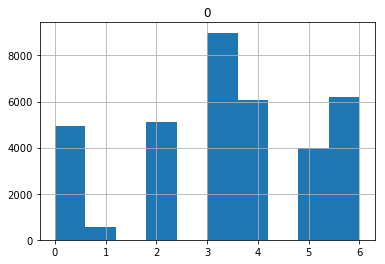

In [7]:
# data distribution
emotions.hist()

In [8]:
# distribution of pictures
emotions[0].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: 0, dtype: int64

In [9]:
# prepare output labels for train, cv and test
y_train = emotions[:images_train.shape[0]].values
y_val = emotions[images_train.shape[0]:images_train.shape[0] + images_val.shape[0]].values
y_test = emotions[images_train.shape[0] + images_val.shape[0]: ].values

In [10]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3589, 1)


In [11]:
# create one hot encoding
y_train_ohe = to_categorical(y_train, num_classes=7)
y_val_ohe = to_categorical(y_val, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [12]:
print(y_train_ohe.shape)
print(y_val_ohe.shape)
print(y_test_ohe.shape)

(28709, 7)
(3589, 7)
(3589, 7)


In [13]:
# for displaying an image from dataset
def show(img):
    # resize the image
    
    show_image = img.reshape(48,48)
    # show the image
    plt.imshow(show_image, cmap='gray')
   # plt.imshow(img, cmap='gray')

Emotion:[0]


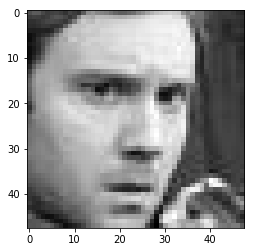

In [14]:
# verify the image with its label
index = 0
# training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:[0]


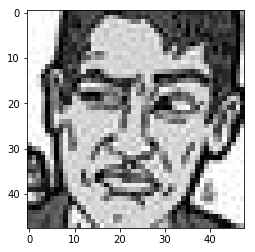

In [15]:
# cv image
show(images_val[index])
print('Emotion:' + str(y_val[index]))

Emotion:[0]


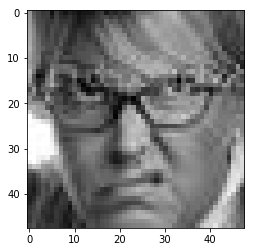

In [16]:
# test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

In [17]:

# reshape the images for keras model
images_train = np.expand_dims(images_train, 3)
images_val = np.expand_dims(images_val, 3)
images_test = np.expand_dims(images_test, 3)

In [18]:
print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [19]:
#from keras.utils import plot_model
#import pydot
#plot_model(model, to_file='model/model.png', show_shapes=True)

In [20]:
# save the model weights after each epoch if the validation loss decreases
checkpoint = ModelCheckpoint(filepath='model/weights_best.hdf5', verbose=1, save_best_only=True)

In [53]:
model = Sequential()

# 1st stage
model.add(Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# 2nd stage
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# 3rd stage
model.add(Conv2D(128, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# FC layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
__________

In [93]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
# start training the model
hist = model.fit(images_train, y_train_ohe, batch_size=128, epochs=5, verbose=1,
          validation_data=(images_val, y_val_ohe), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
model.save_weights('model/weights.h5')
model.save('model/model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 1486s - loss: 2.2983 - acc: 0.2230 - val_loss: 1.6985 - val_acc: 0.3101
Epoch 2/5
28709/28709 [==============================] - 1241s - loss: 1.7315 - acc: 0.3510 - val_loss: 1.4837 - val_acc: 0.4260
Epoch 3/5
28709/28709 [==============================] - 1235s - loss: 1.5061 - acc: 0.4231 - val_loss: 1.3491 - val_acc: 0.4784
Epoch 4/5
28709/28709 [==============================] - 1210s - loss: 1.3666 - acc: 0.4743 - val_loss: 1.3081 - val_acc: 0.4921
Epoch 5/5
28709/28709 [==============================] - 1238s - loss: 1.2819 - acc: 0.5127 - val_loss: 1.2607 - val_acc: 0.5213


In [95]:
# training loss and accuracy
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(images_test, y_test_ohe,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.512661534724
Validation Accuracy:  0.521315129596
3589/3589 [==============================] - 59s    
Test score: 1.25098434568
Test accuracy: 0.519364725559


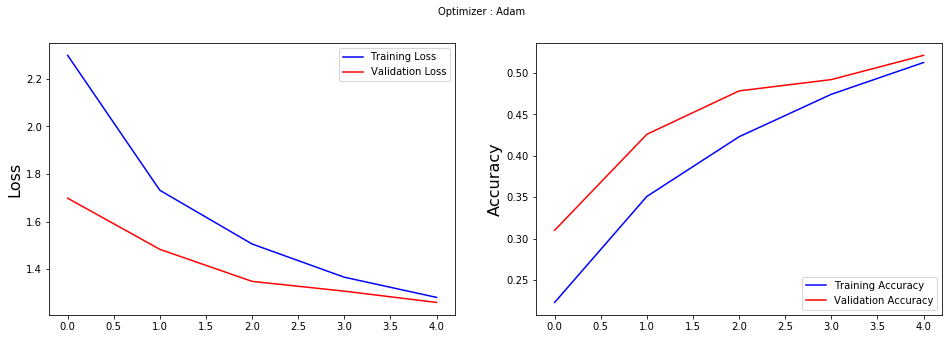

In [96]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [54]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('XCeption/XceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [ ]:


images_data_resized = [scipy.misc.imresize(image, new_shape(7,7,48)) for image in images_train]
  

In [21]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.optimizers import SGD
base_model = InceptionV3(weights='imagenet', include_top=False)

In [22]:
for layer in base_model.layers:
     layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(7, activation='softmax')(x) #new softmax layer
model = Model(input=base_model.input, output=predictions)
model.summary()
...
for layer in model.layers[:172]:
     layer.trainable = False
for layer in model.layers[172:]:
     layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
...

C:\Users\Namita\Anaconda2\envs\dog-project\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0                                            
___________________________________________________________________________________________

Ellipsis

In [ ]:
for layer in model.layers:
     layer.trainable = False

for layer in model.layers[:-3]:
     layer.trainable = True

train_data_x, train_data_y = images_train_set, emotions[:28709].values


val_data_x, val_data_y = images_val_set, emotions[28709:32298].values


### TODO: Train the model.
train_datagen =  ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
)
test_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'data/Training',
    target_size = (299, 299),
    batch_size=7
)

validation_generator = test_datagen.flow_from_directory(
    'data/PrivateTest',
    target_size = (299, 299),
    batch_size=7
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# First: train only the top layers (which were randomly initialized) freezing all convolutional ResNet-50 layers
#for layer in base_model.layers:
#    layer.trainable = False

# Compile (configures the model for training) the model (should be done *AFTER* setting layers to non-trainable)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       Float >= 0. Learning rate
        # beta_1:   Float, 0 < beta < 1. Generally close to 1
        # beta_2:   Float, 0 < beta < 1. Generally close to 1
        # epsilon:  Float >= 0. Fuzz factor
        # decay:    Float >= 0. Learning rate decay over each update
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = Adam(lr = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
# as well as activation histograms for the different layers in your model
    # log_dir:          The path of the directory where to save the log files to be parsed by TensorBoard
    # histogram_freq:   Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    #                   If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations
    # write_graph:      Whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True
    # write_grads:      Whether to visualize gradient histograms in TensorBoard. histogram_freq must be greater than 0
    # write_images:     Whether to write model weights to visualize as image in TensorBoard
# To visualize the files created during training, run in your terminal: tensorboard --logdir path_to_current_dir/Graph
tensorboard_top_layers = TensorBoard(
	log_dir         = '/logs_top_layers',
	histogram_freq  = 0,
	write_graph     = True,
	write_images    = True)

# Train the model on the new data for a few epochs (Fits the model on data yielded batch-by-batch by a Python generator)
    # generator:        A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing
    #                   The output of the generator must be either {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # steps_per_epoch:  Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch
    #                   It should typically be equal to the number of unique samples of your dataset divided by the batch size 
    # epochs:           Integer, total number of iterations on the data
    # validation_data:  This can be either {a generator for the validation data } {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # callbacks:        List of callbacks to be called during training (to visualize the files created during training, run in your terminal:
    #                   tensorboard --logdir path_to_current_dir/Graph)

  
    
model.fit_generator(
    generator           = train_generator,
    steps_per_epoch     = 4000,  # samples_per_epoch / batch_size
    epochs              = 5,                            
    validation_data     = validation_generator,
    validation_steps    = 50,
    callbacks           = [tensorboard_top_layers])

model.save_weights('model/inception_weight.h5')
model.save('model/inception.h5')

Epoch 1/5
 503/4000 [==>...........................] - ETA: 48960s - loss: 1.8663 - acc: 0.2553

In [97]:
# read image 
images = []
for filename in os.listdir('test_images\\'):
    path = os.path.join('test_images\\', filename)
    images.append(cv2.imread(path, -1))

In [98]:
# do prediction for the images
predictions = []
for img in images:
    # change to greyscale
    curr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    curr_img = cv2.resize(curr_img, (48,48))
    curr_img = np.reshape(curr_img, (1, 48, 48, 1))
    predictions.append(np.argmax(model.predict(curr_img)))
    print(curr_img)

[[[[132]
   [131]
   [129]
   ..., 
   [142]
   [150]
   [147]]

  [[131]
   [129]
   [128]
   ..., 
   [109]
   [140]
   [145]]

  [[125]
   [125]
   [124]
   ..., 
   [ 94]
   [142]
   [139]]

  ..., 
  [[154]
   [145]
   [143]
   ..., 
   [110]
   [ 89]
   [ 67]]

  [[141]
   [135]
   [135]
   ..., 
   [200]
   [156]
   [ 72]]

  [[130]
   [133]
   [133]
   ..., 
   [185]
   [206]
   [207]]]]
[[[[234]
   [234]
   [233]
   ..., 
   [227]
   [225]
   [225]]

  [[235]
   [235]
   [235]
   ..., 
   [227]
   [227]
   [227]]

  [[235]
   [235]
   [235]
   ..., 
   [227]
   [227]
   [227]]

  ..., 
  [[241]
   [241]
   [240]
   ..., 
   [233]
   [233]
   [233]]

  [[241]
   [241]
   [240]
   ..., 
   [229]
   [233]
   [233]]

  [[238]
   [237]
   [236]
   ..., 
   [225]
   [230]
   [230]]]]
[[[[105]
   [107]
   [108]
   ..., 
   [154]
   [154]
   [154]]

  [[105]
   [107]
   [108]
   ..., 
   [154]
   [154]
   [154]]

  [[106]
   [106]
   [108]
   ..., 
   [155]
   [155]
   [155]]

  ..., 

In [99]:
# list of given emotions
EMOTIONS = ['Angry', 'Disgusted', 'Fearful',
            'Happy', 'Sad', 'Surprised', 'Neutral']

In [100]:
# bgr to rgb
for i in range(1):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

Predicted Emotion: Happy


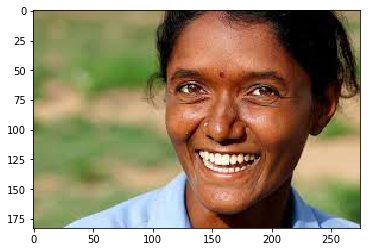

In [101]:
plt.imshow(images[0])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[0]]))

Predicted Emotion: Neutral


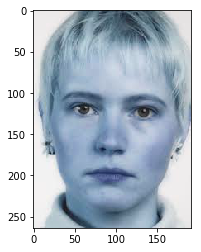

In [102]:
plt.imshow(images[1])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[1]]))

Predicted Emotion: Surprised


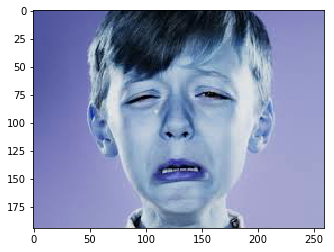

In [103]:
plt.imshow(images[2])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[2]]))